# This is an introduction to working with images in neural networks

# This is **NOT** original work. 

# All credit to Computer Science's "Classify Images Using Python & Machine Learning" Video on Youtube

https://www.youtube.com/watch?v=iGWbqhdjf2s

This notebook serves as a guide for understanding the general process which we will use for our classification of MRI scanned brain images for varying degrees of Alzheimers.

As of right now (3/21/2023), we plan to use a Neural Network to classify the images.
We also aim to use an alternative method of classification that we have previously learned in class, but we predict that the neural network will prove to have the best results.

We have not yet covered Neural Networks in class, so this notebook is an introduction into the topic. However, we will **NOT** follow these steps directly in our approach. 

For example, we will certainly need to test varying degrees of granularity for the image quality.
I expect it to be infeasible to use the full quality of the images, as it may result in increased training times.
However, using less quality images would result in lesser accuracy, which is not acceptable either.

Within our project, we will use some form of cross validation to find a meaningful balance between these trade-offs.

### Imports

There are several imports that must be made.
Using the virtual environment requirements for this class, no installations must be made to import the following into the notebook

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
# This cell is necessary for avoiding permission errors when getting the dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Fetching the Dataset

We will use the cifar10 dataset from keras.datasets
This provides training and test sets of images, which are already in numpy array format

Note that each feature is a 32x32 image (so very poor quality), and each pixel is represented as an RGB value (np array of 3 elements)
Note that each label is an integer value that represents the true classification of the image

In [4]:
# Load the data
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [9]:
# A dataset from keras is of type...
print(type(x_train))

<class 'numpy.ndarray'>


In [11]:
# Showing shape of arrays
print('x_train shape:', x_train.shape) # 50000 rows with (32 x 32 with depth 3 for RGB)
print('x_test shape:', x_test.shape) # 10000 rows with (32 x 32 with depth of 3 for RGB)
print('y_train shape:', y_train.shape) # 50000 rows with 1 column
print('y_test shape:', y_test.shape) # 10000 rows with 1 column

x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)


In [12]:
# Take a look at the first image as an array:
index = 0
x_train[index]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

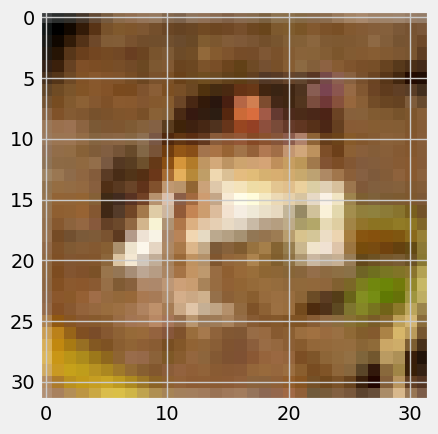

In [13]:
# Showing it as a picture now...
img = plt.imshow(x_train[index])

In [14]:
# Get the image label
print("The first training data image is:", y_train[index])

The first training data image is: [6]


In [15]:
# Every number corresponds to a classification
classification = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [18]:
print("The first training data image is of class:", classification[y_train[index][0]])

The first training data image is of class: frog


### Conver to One-Hot Encoding

In order to make our data easier to work with (and more reliable), we will convert classifications into a One-Hot format
The transformation goes as follows:

&nbsp;&nbsp;&nbsp;0: [1 0 0 0 0 0 0 0 0 0] <br />
&nbsp;&nbsp;&nbsp;1: [0 1 0 0 0 0 0 0 0 0] <br />
&nbsp;&nbsp;&nbsp;2: [0 0 1 0 0 0 0 0 0 0] <br />
&nbsp;&nbsp;&nbsp;3: [0 0 0 1 0 0 0 0 0 0] <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;... <br />
&nbsp;&nbsp;&nbsp;9: [0 0 0 0 0 0 0 0 0 1]

In [19]:
# Convert labels into a set of 10 numbers to input into the neural network
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [35]:
print("y_train_one_hot example:", y_train_one_hot[0], "which corresponds to", \
      classification[(np.where(y_train_one_hot[0] == 1))[0][0]])
print("y_test_one_hot example:", y_test_one_hot[0], "which corresponds to", \
      classification[(np.where(y_test_one_hot[0] == 1))[0][0]])

y_train_one_hot example: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] which corresponds to frog
y_test_one_hot example: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] which corresponds to cat


# Normalize Training Data

Each value within the RGB value of a pixel ranges from 0-255
Thus, we can normalize the data between 0 and 1 by dividing each by 255

In [36]:
# Normalize the pixels to be values between 0 and 1
x_train = x_train / 255
x_test = x_test / 255

In [37]:
# New first image on the training set (now it is normalized)
x_train[index]

array([[[0.23137255, 0.24313725, 0.24705882],
        [0.16862745, 0.18039216, 0.17647059],
        [0.19607843, 0.18823529, 0.16862745],
        ...,
        [0.61960784, 0.51764706, 0.42352941],
        [0.59607843, 0.49019608, 0.4       ],
        [0.58039216, 0.48627451, 0.40392157]],

       [[0.0627451 , 0.07843137, 0.07843137],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509804, 0.21568627],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117647, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215686, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941176, 0.19607843],
        [0.47058824, 0.32941176, 0.19607843],
        [0.42745098, 0.28627451, 0.16470588]],

       ...,

       [[0.81568627, 0.66666667, 0.37647059],
        [0.78823529, 0.6       , 0.13333333],
        [0.77647059, 0

# Model Creation

We have not yet covered this, so this should not make too much sense yet
For now, we should simply recognize that a neural network model is created which we will train using our training data and the one-hot encoded classifications of the training set

In [38]:
# Creating the model's architecture
model = Sequential()

# Add the first layer (convolution layer)
# Extract features from input image'
# Create 32 5x5 relu convoluted feature maps
model.add(Conv2D(32, (5,5), activation='relu', input_shape=(32, 32, 3)))

# Create another layer - Pooling layer
# Create a pooling layer with 2x2 pixel filter to get max element from the feature map
model.add(MaxPooling2D(pool_size=(2,2)))

# Add another convolution layer
model.add(Conv2D(32, (5,5), activation='relu'))

# Add another pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Add a flattening layer
# This reduces dimensionality to a linear array
model.add(Flatten())

# Now create a layer with 1000 neurons
model.add(Dense(1000, activation='relu'))

# Now add a drop out layer with a 50% drop out rate
model.add(Dropout(0.5))

# Now create a layer with 500 neurons
model.add(Dense(500, activation='relu'))

# Now add a drop out layer with a 50% drop out rate
model.add(Dropout(0.5))

# Now create a layer with 250 neurons
model.add(Dense(250, activation='relu'))

# Now create a layer with 10 neurons, now with a softmax activation function
model.add(Dense(10, activation='softmax'))

In [39]:
# Compile the model
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [40]:
# Train the model now...
hist = model.fit(x_train, 
                 y_train_one_hot, 
                 batch_size=256, 
                 epochs=10, 
                 validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 36s 214ms/step - loss: 1.8531 - accuracy: 0.3129 - val_loss: 1.5685 - val_accuracy: 0.4242
Epoch 2/10
157/157 [==============================] - 33s 211ms/step - loss: 1.5037 - accuracy: 0.4478 - val_loss: 1.4612 - val_accuracy: 0.4735
Epoch 3/10
157/157 [==============================] - 35s 225ms/step - loss: 1.3756 - accuracy: 0.4991 - val_loss: 1.4346 - val_accuracy: 0.4872
Epoch 4/10
157/157 [==============================] - 36s 229ms/step - loss: 1.2886 - accuracy: 0.5366 - val_loss: 1.2342 - val_accuracy: 0.5575
Epoch 5/10
157/157 [==============================] - 34s 219ms/step - loss: 1.2046 - accuracy: 0.5702 - val_loss: 1.1782 - val_accuracy: 0.5782
Epoch 6/10
157/157 [==============================] - 34s 216ms/step - loss: 1.1397 - accuracy: 0.5914 - val_loss: 1.1013 - val_accuracy: 0.6064
Epoch 7/10
157/157 [==============================] - 34s 213ms/step - loss: 1.0758 - accuracy: 0.6176 - val_loss: 1.1538 - val_ac

In [44]:
# We will now evaluate the model using the test data set
accuracy = model.evaluate(x_test, y_test_one_hot)[1]
print("{:.2f}% accuracy on the test set.".format(accuracy * 100))

313/313 [==============================] - 4s 13ms/step - loss: 1.0027 - accuracy: 0.6421
64.21% accuracy on the test set.


### Visualizing Model Training Process

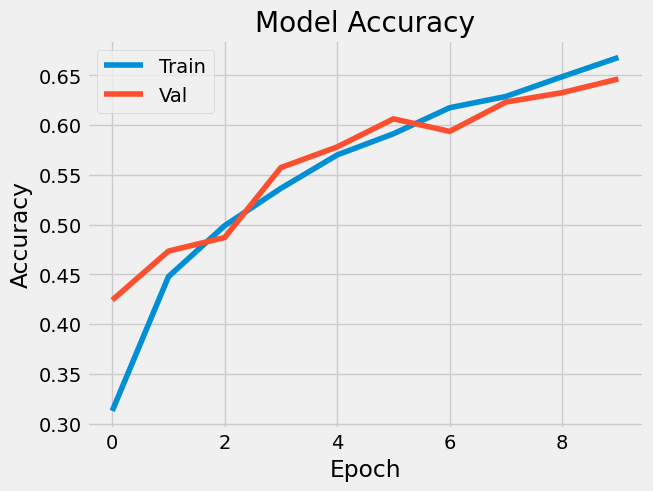

In [46]:
# 64.21% is not amazing... decent enough???
# Visualize the model's accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

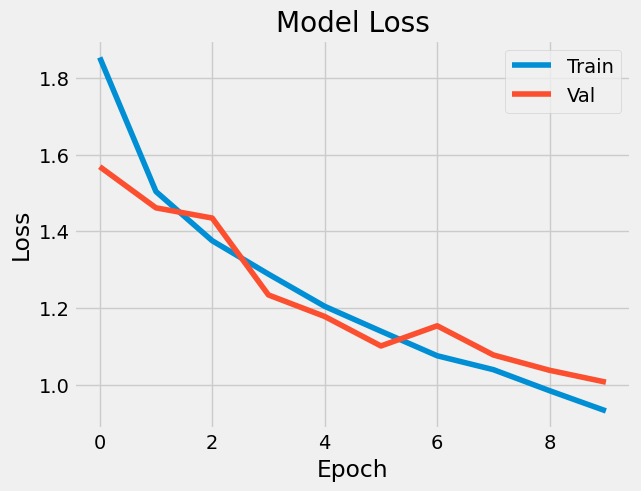

In [47]:
# Visualize the model's loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Testing Using Brand New Data

Now that we have fully trained our model, we can present it with completely new information to see if it can adequately identify what it believes it to be

Note that it is important that the data is presented in a form that the model can interact with

In our case, that means that any input images must be 32 x 32 with each pixel having an RGB value

In order to accomplish this, we can use existing algorithms for image transformations

In [48]:
# Test the model with an example of our own

Raw Image:

![Airplane](./Images_For_Checkpoint/airplane_image.jpg)

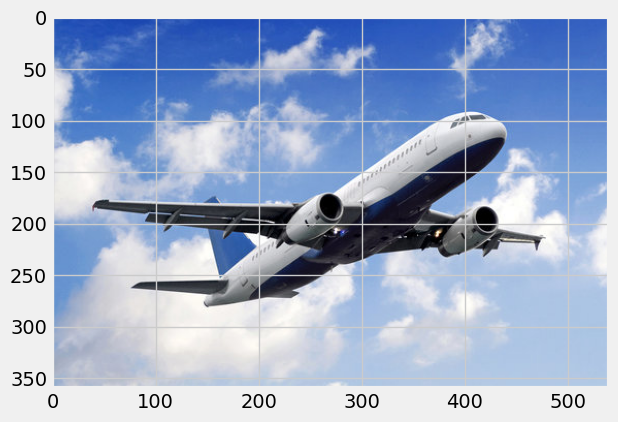

In [49]:
# Using plt to read the image
new_image = plt.imread('./Images_For_Checkpoint/airplane_image.jpg')
img = plt.imshow(new_image)

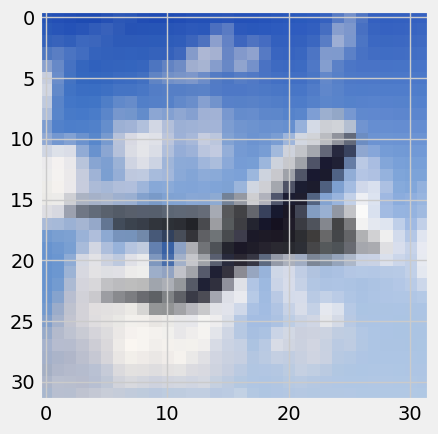

In [50]:
# We need to make this image 32x32 with depth 3 in order for our neural network to use it

# Resize the image
from skimage.transform import resize
resized_image = resize(new_image, (32, 32, 3))
img = plt.imshow(resized_image)

In [51]:
# Let's see if we can actually predict this image
# Get the model's predictions
predictions = model.predict(np.array([resized_image]))

# Show the predictions
predictions

1/1 [==============================] - 0s 344ms/step


array([[9.9928540e-01, 1.2844410e-04, 1.9016165e-04, 4.1980338e-06,
        1.2370574e-04, 4.2036203e-07, 4.2711210e-07, 9.0013073e-06,
        2.5498097e-05, 2.3270401e-04]], dtype=float32)

In [57]:
for i in range(len(classification)):
    print("Prediction for", classification[i], "is: {:.2f}%".format(predictions[0][i] * 100))

Prediction for airplane is: 99.93%
Prediction for automobile is: 0.01%
Prediction for bird is: 0.02%
Prediction for cat is: 0.00%
Prediction for deer is: 0.01%
Prediction for dog is: 0.00%
Prediction for frog is: 0.00%
Prediction for horse is: 0.00%
Prediction for ship is: 0.00%
Prediction for truck is: 0.02%
